In [1]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh

In [2]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [3]:
s = ctl.TransferFunction.s
G = 1/(s**2 + 2*s)
G_bkp = G
G

TransferFunction(array([1]), array([1, 2, 0]))

polos:  (-2+0j) 0j
zeros: 


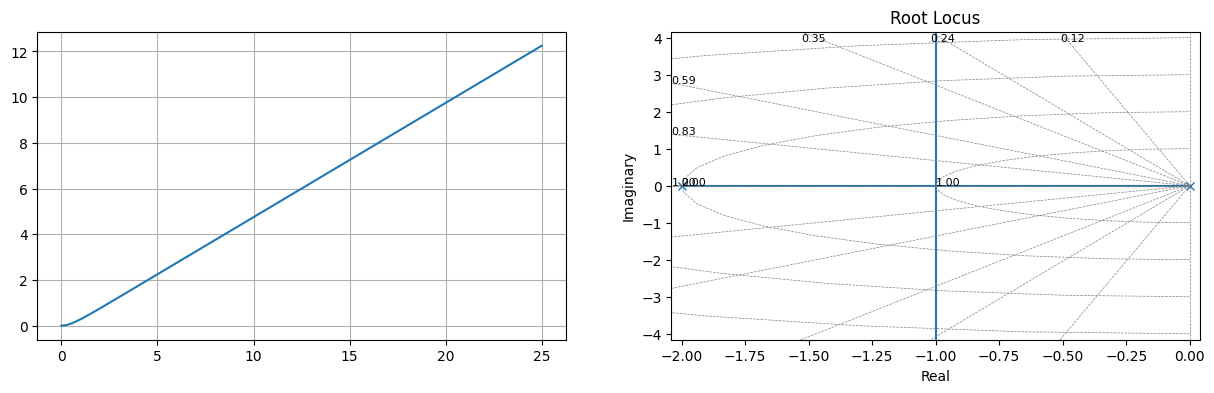

In [4]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# REQUISITOS DO SISTEMA
- Os requisitos do sistema serão encontrados a partir do overshoot e tempo de establização máximos permitidos

In [5]:
Ts = 3
UP = .5

- $\zeta = -\frac{ln(UP\%)}{\sqrt{\pi² + ln²(UP\%)}}$

In [6]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.2154537619662468

- $\omega_n = \frac{4}{\zeta\,t_s}$ 

In [7]:
Wn = 4/(zeta*Ts)
Wn

6.188489452053358

- $s_d = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [8]:
s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)

s_d

-1.333 + 6.043*I

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K\cdot\frac{(s-a)(s-b)}{s(s-p)}$
- $p$ é um polo colocado arbitrariamente pois o número de polos tem que ser maior ou igual o número de zeros. Esse polo $p$ precisa estar longe do eixo imaginário para que tenha pouca influência no sistema

In [9]:
s = sp.symbols('s')
p = -20
K, a, b = sp.symbols('K a b', real=True)

C = K * ((s - a) * (s - b)) / (s * (s - p))
C

K*(-a + s)*(-b + s)/(s*(s + 20))

In [10]:
GC = sympyFunction(G) * C
GC

K*(-a + s)*(-b + s)/(s*(s + 20)*(s**2 + 2*s))

### CONSTANTE DO PRIMEIRO ZERO
- Opção 1: $a$ deve ser um zero que irá cortar com um polo **ESTÁVEL** do sistema, ou seja, localizado no semiplano **ESQUERDO**
- Opção 2: $a$ deve cortar com a parte real do polo estável projetado com $s_d$, caso o seu sistema não tenha outros polos estáveis

In [11]:
a_desired = float(sp.re(s_d))

GC = GC.subs(a, a_desired)
GC

K*(-b + s)*(s + 1.33299255371094)/(s*(s + 20)*(s**2 + 2*s))

In [12]:
a = a_desired
a

-1.3329925537109375

### EQUAÇÃO 1 - SOMA DOS ÂNGULOS
- A soma dos angulos da função de transferência em malha aberta + 180º é igual a zero para o $s$ desejado

In [13]:
G_aux = GC.subs(K, 1).subs(s, s_d)
angle = sp.arg(G_aux)
angle = roundSympyFunction(angle)

eq = sp.Eq(angle + sp.pi, 0)
eq

Eq(arg(-I*(1.333 + 6.043*I)*(18.67 - 6.043*I)*(-b - 1.333 + 6.043*I)/(-2.666 + (-1.333 + 6.043*I)**2 + 12.09*I)) + pi, 0)

In [14]:
b_desired = sp.nsolve(eq, b, 0)
b_desired = float(b_desired)
b_desired

-9.496794389883618

In [15]:
GC = GC.subs(b, b_desired)
b  = b_desired

GC

K*(s + 1.33299255371094)*(s + 9.49679438988362)/(s*(s + 20)*(s**2 + 2*s))

### EQUAÇÃO 3 - MÓDULO
- O módulo da função de transferência em malha aberta é igual a 1 para o $s$ desejado

In [16]:
G_aux  = GC.subs(s, s_d)
modulo = sp.Abs(G_aux).expand().simplify()
modulo = roundSympyFunction(modulo)

eq = sp.Eq(modulo - 1, 0)
eq

Eq(0.013436*Abs(K) - 1, 0)

In [17]:
K = sp.nsolve(eq, K, 0)
K = float(K)
K

74.42688773671223

# RESPOSTA CONTROLADA

In [18]:
s = ctl.TransferFunction.s

C = K * ((s - a) * (s - b)) / (s * (s - p))
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([ 74.42688774, 806.02733706, 942.18159777]), array([ 1, 22, 40,  0,  0]))

In [19]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([ 74.42688774, 806.02733706, 942.18159777]), array([  1.        ,  22.        , 114.42688774, 806.02733706,
       942.18159777]))

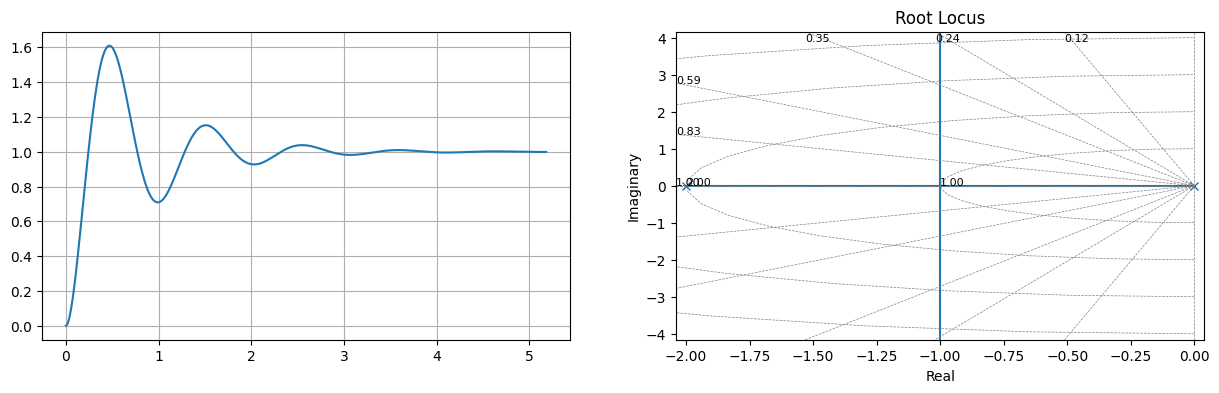

In [20]:
time, response = ctl.step_response(G_feedback)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

In [21]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.6111709641439717
valor de pico:  1.6093659948470032
tempo de pico:  0.4684816326900986
tempo de assentamento:  2.7340895284864772
valor final:  0.9988797158482015
erro:  0.0011202841517985451


# APLICANDO VÁRIOS STEPS

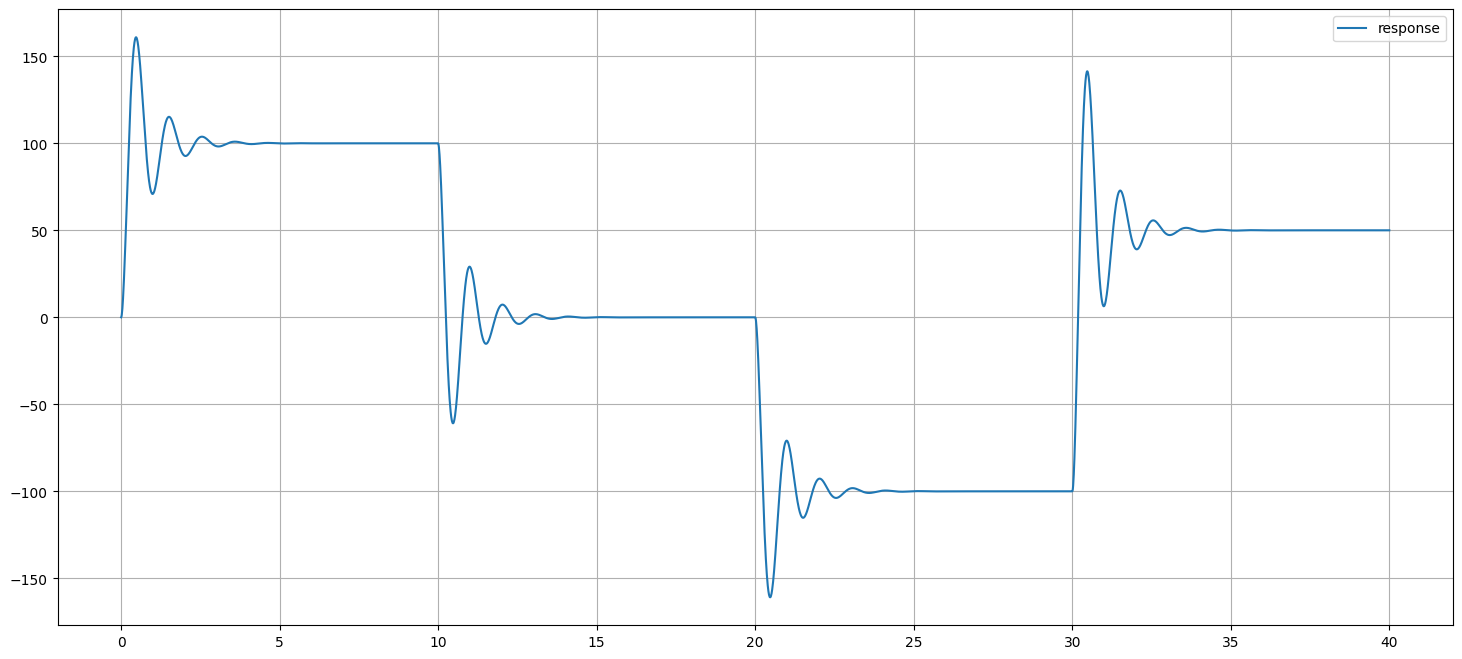

In [22]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()

# APLICANDO VÁRIOS STEPS

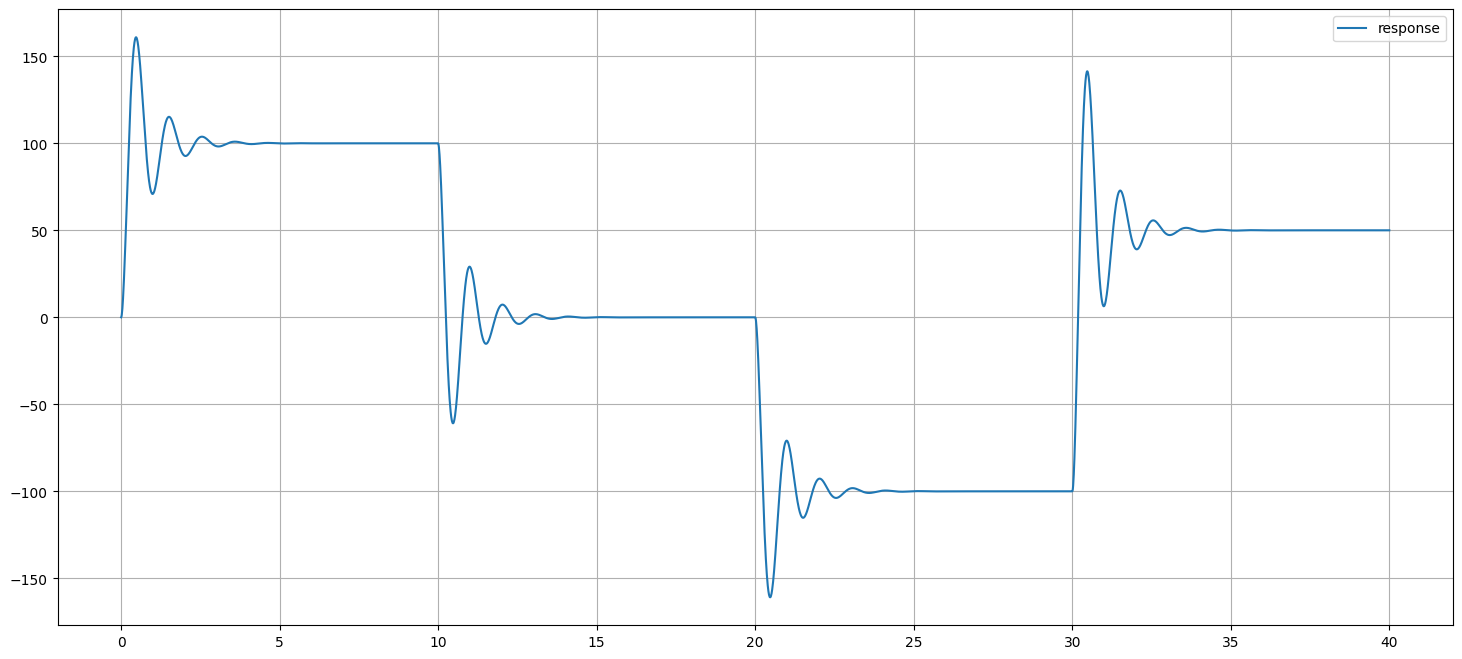

In [23]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()